# 01_DATA_QC_PREP — Quality Check y Splits Estratificados

**Qué hace este notebook (QC básico):**
1. **Carga** cada `driving_log.csv` de los recorridos seleccionados (`RUNS`), admitiendo estructuras con **subcarpetas** (p. ej., `circuito1/vuelta1`, `circuito1/vuelta2`, …).
2. **Normaliza rutas** de imagen (corrige barras invertidas y reduce a rutas relativas tipo `IMG/...`).
3. **Filtra filas inválidas** (imágenes inexistentes en `center/left/right`).
4. Realiza **split estratificado por bins de `steering`** con semilla fija (reproducible).
5. **Escribe**:
   - `data/processed/<run>/canonical.csv`
   - `data/processed/<run>/{train,val,test}.csv`
   - `data/processed/tasks.json` (orden de tareas y rutas a CSV)


> **QC = *Quality Check***: validación y normalización de datos **sin balanceo ni aumentación offline**.  
> Si quieres **balancear** el `train` por bins (con generación de imágenes aumentadas) y **activar la expansión left/right con corrección de `steer_shift`**, usa el cuaderno [`01A_PREP_BALANCED.ipynb`]. **Puedes ejecutar 01A directamente**: incluye su propia fase de *prep* antes de balancear.

---

## 🎯 Objetivos
- Preparar los *splits* `train/val/test` por recorrido
- Generar `tasks.json` para el pipeline *continual*.

## ✅ Prerrequisitos
- Estructura de datos RAW del simulador Udacity, p. ej.:
   - `data/raw/udacity/circuito1/vuelta1/{driving_log.csv, IMG/}`
   - `data/raw/udacity/circuito1/vuelta2/{driving_log.csv, IMG/}`
   - `data/raw/udacity/circuito2/vuelta1/{driving_log.csv, IMG/}`

> *(las vueltas pueden variar; el notebook detecta y consolida sus rutas en `canonical.csv`).*

## ⚠️ Salidas
- CSVs canónicos y de split en `data/processed/<run>/`.
- `tasks.json` apuntando a esos CSVs  (orden de tareas para *continual learning*).

> Si más adelante quieres **balanceo offline de `train` por bins** (con aumentación fotométrica) y/o **expansión por cámaras izquierda/derecha (L/R)** con corrección de ángulo, usa `01A_PREP_BALANCED.ipynb` (no requiere ejecutar este notebook previamente).

<a id="toc"></a>

## 🧭 Índice
1. [Entorno y API de preparación](#sec-01)
2. [Parámetros de la preparación](#sec-02)
3. [Ejecutar pipeline y verificar](#sec-03)
4. [Resumen de rutas de splits (vista rápida)](#sec-04)
5. [EDA rápida por circuito (opcional)](#sec-05)

## <a id="sec-01"></a>

## 1) Entorno y API de preparación

**Objetivo:** preparar el entorno y cargar la API de *prep*.

Esta celda:
- Detecta la raíz del repo (`ROOT`) y la añade a `sys.path`.
- Importa la API de `src.prep.data_prep`:
  - `PrepConfig` — configuración declarativa de la preparación.
  - `run_prep` — ejecuta QC + *splits* estratificados y crea `tasks.json`.
  - `verify_processed_splits` — comprueba que `train/val/test.csv` existen por *run*.
- Define rutas base:
  - `RAW = data/raw/udacity`
  - `PROC = data/processed`

> Aquí **no se ejecuta** todavía la preparación; sólo se deja el entorno listo.

[↑ Volver al índice](#toc)


In [1]:
# %% setup & imports
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys, json
import pandas as pd

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.prep.data_prep import PrepConfig, run_prep, verify_processed_splits

RAW  = ROOT / "data" / "raw" / "udacity"
PROC = ROOT / "data" / "processed"

print("ROOT:", ROOT)
print("RAW :", RAW)
print("PROC:", PROC)


ROOT: /home/cesar/proyectos/TFM_SNN
RAW : /home/cesar/proyectos/TFM_SNN/data/raw/udacity
PROC: /home/cesar/proyectos/TFM_SNN/data/processed


## <a id="sec-02"></a>

## 2) Parámetros de la preparación

**Objetivo:** declarar los *runs* y la configuración del *split* (QC básico).

- `RUNS`: lista de recorridos a procesar (p. ej., `["circuito1", "circuito2"]`).  
  Cada recorrido puede contener **múltiples subcarpetas de vueltas** (`vuelta1/`, `vuelta2/`, …) que el *prep* consolidará en `canonical.csv`.
- `use_left_right=False`: en este cuaderno mantenemos un **QC sin expansión L/R** (no triplica filas ni aplica `steer_shift`).  
  > Si deseas activar **expansión L/R + corrección de ángulo** y **balanceo offline por bins**, emplea `01A_PREP_BALANCED.ipynb` (recomendado para comparativas).
- `bins`: número de contenedores para **estratificar `steering`** en los *splits* (mitiga sesgo a “recta”).
- `train/val`: proporciones del *split* (test se infiere).
- `seed`: fija reproducibilidad del *split*.

> `target_per_bin` y `cap_per_bin` **no se usan aquí**. Son parámetros del **balanceo offline por imágenes** en `01A_PREP_BALANCED.ipynb`.

[↑ Volver al índice](#toc)


In [2]:
# Parámetros de la preparación
RUNS = ["circuito1", "circuito2"]

CFG = PrepConfig(
    root=ROOT,
    runs=RUNS,
    merge_subruns=True,      # Consolida vuelta1/vuelta2/... (recomendado)
    use_left_right=False,    # QC + split básico (sin expansión L/R)
    steer_shift=0.2,         # sin efecto si use_left_right=False
    bins=50,
    train=0.70,
    val=0.15,
    seed=42,
    # No se usan aquí (balanceo offline es en 01A):
    target_per_bin=None,
    cap_per_bin=None,
)

CFG


PrepConfig(root=PosixPath('/home/cesar/proyectos/TFM_SNN'), runs=['circuito1', 'circuito2'], use_left_right=False, steer_shift=0.2, bins=50, train=0.7, val=0.15, seed=42, target_per_bin=None, cap_per_bin=None, merge_subruns=True)

## <a id="sec-03"></a>
## 3) Ejecutar pipeline y verificar

**Objetivo:** correr el pipeline de **QC + splits** y **validar** la existencia de los CSV.

- `run_prep(CFG)`:
  - Lee y **normaliza** cada `driving_log.csv` (admite subcarpetas) → `canonical.csv`.
  - Crea **splits estratificados** (`train.csv`, `val.csv`, `test.csv`) con semilla fija.
  - Construye/actualiza `data/processed/tasks.json` con el **orden de tareas** y rutas.
- `verify_processed_splits(PROC, RUNS)`:
  - Comprueba que `train/val/test.csv` existen para cada *run*; si falta algo, lanza una excepción.
- **Idempotente**: puedes re-ejecutar esta celda sin efectos secundarios.

[↑ Volver al índice](#toc)


In [3]:
manifest = run_prep(CFG)
print("OK:", PROC / "prep_manifest.json")

verify_processed_splits(PROC, RUNS)
print("OK: splits 'train/val/test' encontrados por run.")

print("\nResumen de salidas registradas en manifest['outputs']:")
for k, v in manifest.get("outputs", {}).items():
    print(f" - {k}: {v}")


OK: /home/cesar/proyectos/TFM_SNN/data/processed/prep_manifest.json
OK: splits 'train/val/test' encontrados por run.

Resumen de salidas registradas en manifest['outputs']:
 - tasks_json: /home/cesar/proyectos/TFM_SNN/data/processed/tasks.json
 - tasks_balanced_json: None


## <a id="sec-04"></a>
## 4) Resumen de rutas de *splits* (vista rápida)

**Objetivo:** visualizar de un vistazo qué ficheros usará el pipeline *continual*.  
Lee `data/processed/tasks.json` y muestra una tabla con columnas `run`, `train_csv`, `val_csv`, `test_csv`.

Si las rutas no son las esperadas, revisa:
- La lista `RUNS` (celda 2),
- La estructura de `data/raw/udacity/<run>/vuelta*/`,
- Que `IMG/` contenga las imágenes referenciadas.

[↑ Volver al índice](#toc)


In [4]:
tasks_path = PROC / "tasks.json"
assert tasks_path.exists(), f"No existe {tasks_path}. ¿Ejecutaste la celda 3?"
tasks_json = json.loads(tasks_path.read_text(encoding="utf-8"))

pd.DataFrame({
    "run": tasks_json["tasks_order"],
    "train_csv": [tasks_json["splits"][r]["train"] for r in tasks_json["tasks_order"]],
    "val_csv":   [tasks_json["splits"][r]["val"]   for r in tasks_json["tasks_order"]],
    "test_csv":  [tasks_json["splits"][r]["test"]  for r in tasks_json["tasks_order"]],
})


,run,train_csv,val_csv,test_csv
0,circuito1,/home/cesar/proyectos/TFM_SNN/data/processed/c...,/home/cesar/proyectos/TFM_SNN/data/processed/c...,/home/cesar/proyectos/TFM_SNN/data/processed/c...
1,circuito2,/home/cesar/proyectos/TFM_SNN/data/processed/c...,/home/cesar/proyectos/TFM_SNN/data/processed/c...,/home/cesar/proyectos/TFM_SNN/data/processed/c...


## <a id="sec-05"></a>
## 5) EDA rápida por circuito (opcional)

**Qué proporciona:**
- Histogramas de `steering` por split.
- Tabla de **cuentas por bin** → `eda/bins_counts.csv` (útil para la memoria).
- Resumen JSON por circuito con los principales contadores.

> Nota: aquí **no** expandimos L/R, por lo que el *factor de expansión* debería ser ≈ 1.0.

[↑ Volver al índice](#toc)

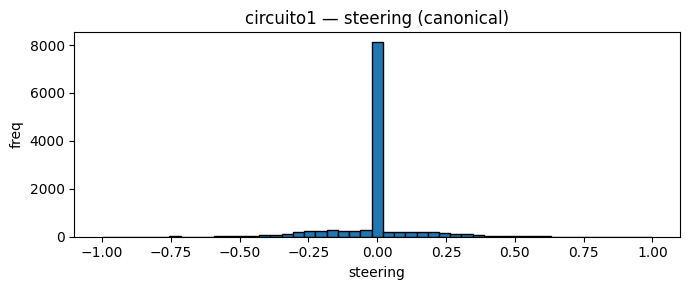

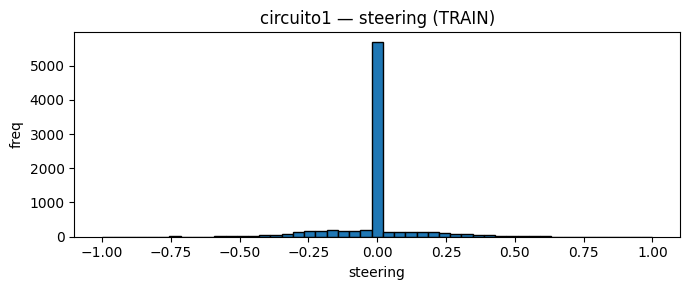

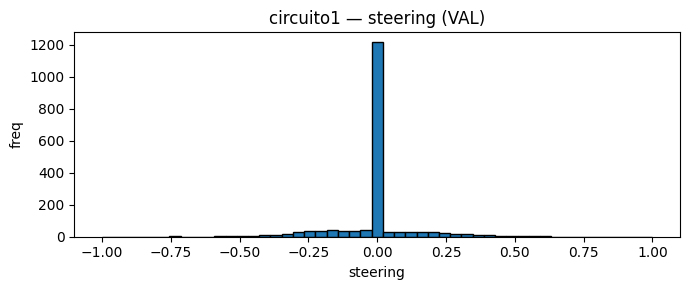

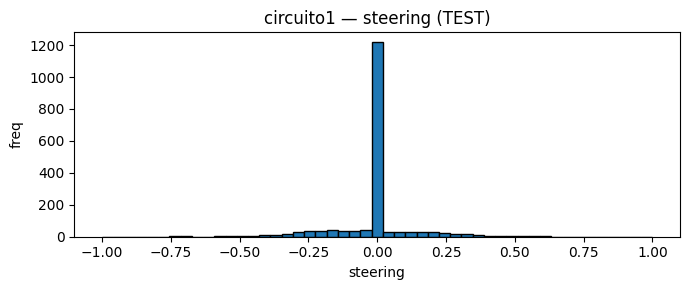

[circuito1] guardado: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/eda/bins_counts.csv


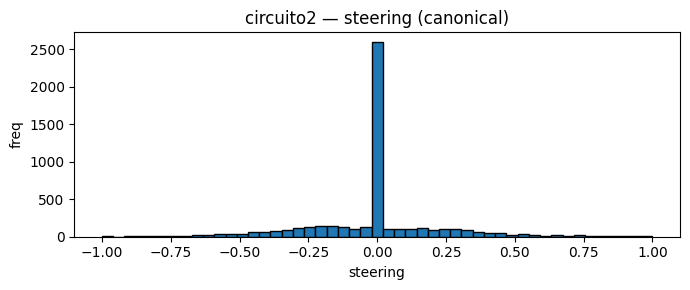

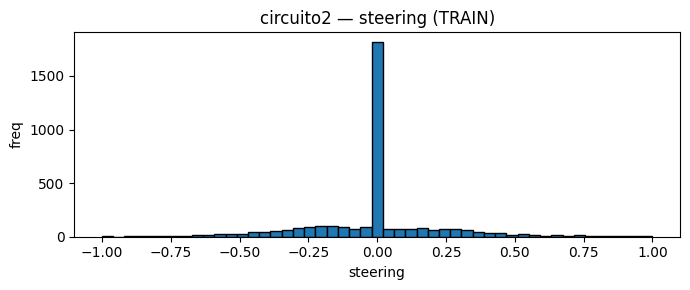

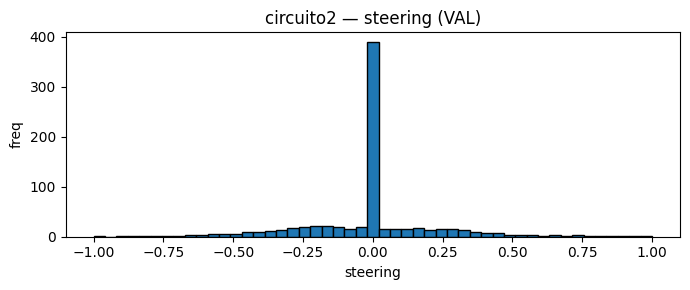

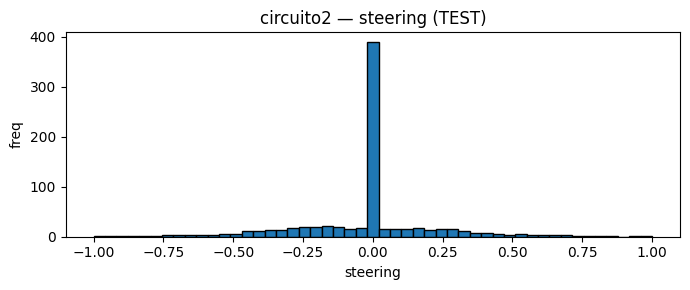

[circuito2] guardado: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/eda/bins_counts.csv


In [5]:
import numpy as np, matplotlib.pyplot as plt

def _plot_hist(series, title, edges, save_path=None):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1, 1)
    plt.figure(figsize=(7, 3))
    plt.hist(s, bins=edges, edgecolor="black")
    plt.title(title); plt.xlabel("steering"); plt.ylabel("freq")
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=140)
    plt.show(); plt.close()

def _bin_counts(series, edges):
    s = pd.to_numeric(series, errors="coerce").dropna().clip(-1,1)
    idx = pd.cut(s, bins=edges, include_lowest=True, labels=False)
    vc = idx.value_counts().sort_index()
    labels = [
        (f"[{edges[i]:.2f},{edges[i+1]:.2f})" if i < len(edges)-2 else f"[{edges[i]:.2f},{edges[i+1]:.2f}]")
        for i in range(len(edges)-1)
    ]
    return pd.DataFrame({"bin": labels, "count": vc.reindex(range(len(edges)-1)).fillna(0).astype(int).values})

bins = CFG.bins
edges = np.linspace(-1.0, 1.0, bins)

for run in RUNS:
    base_out = PROC / run
    df_c  = pd.read_csv(base_out / "canonical.csv")
    df_tr = pd.read_csv(base_out / "train.csv")
    df_va = pd.read_csv(base_out / "val.csv")
    df_te = pd.read_csv(base_out / "test.csv")

    eda_dir = base_out / "eda"

    _plot_hist(df_c["steering"],  f"{run} — steering (canonical)", edges, eda_dir/"hist_canonical.png")
    _plot_hist(df_tr["steering"], f"{run} — steering (TRAIN)",    edges, eda_dir/"hist_train.png")
    _plot_hist(df_va["steering"], f"{run} — steering (VAL)",      edges, eda_dir/"hist_val.png")
    _plot_hist(df_te["steering"], f"{run} — steering (TEST)",     edges, eda_dir/"hist_test.png")

    tbl = (_bin_counts(df_c["steering"], edges).rename(columns={"count":"count_canonical"})
           .merge(_bin_counts(df_tr["steering"], edges).rename(columns={"count":"count_train"}), on="bin")
           .merge(_bin_counts(df_va["steering"], edges).rename(columns={"count":"count_val"}), on="bin")
           .merge(_bin_counts(df_te["steering"], edges).rename(columns={"count":"count_test"}), on="bin"))
    eda_dir.mkdir(parents=True, exist_ok=True)
    tbl.to_csv(eda_dir/"bins_counts.csv", index=False)
    print(f"[{run}] guardado:", eda_dir/"bins_counts.csv")
